In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from planners.lazy_prm import LazyPRM
from utils.lazy_prm_visualize import lazy_prm_visualize
from utils.collision_checker import CollisionChecker
from environment import get_all_scenes
import time
import pandas as pd
from scipy.spatial.distance import euclidean

In [3]:
# ---- Konfiguration für LazyPRM ----
config = {
    "initialRoadmapSize": 150,
    "updateRoadmapSize": 50,
    "kNearest": 10,
    "maxIterations": 25
}

# ---- Alle Szenen durchlaufen + Benchmark ----
scenes = get_all_scenes()
results = []


🔍 Szene: U-Shape
✅ Pfad gefunden in Szene: U-Shape, Länge: 11


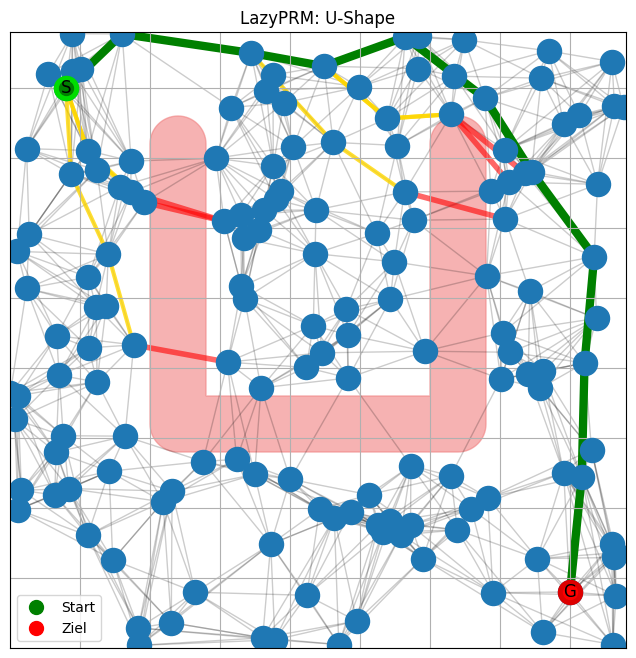


🔍 Szene: L-Shape
❌ Kein Pfad gefunden in Szene: L-Shape


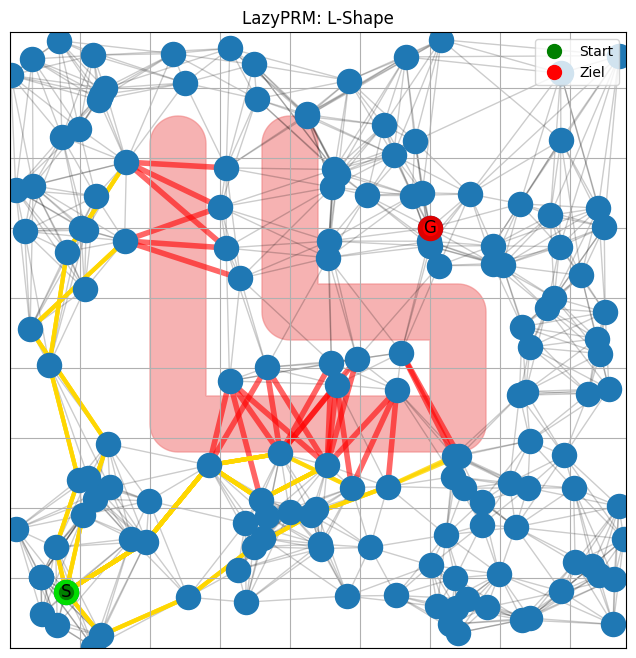


🔍 Szene: Corridor
✅ Pfad gefunden in Szene: Corridor, Länge: 13


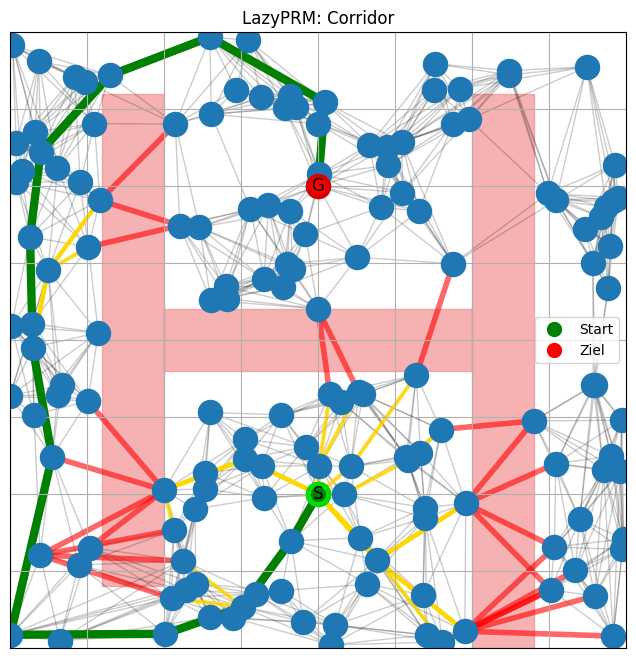


🔍 Szene: Complex Shape
❌ Kein Pfad gefunden in Szene: Complex Shape


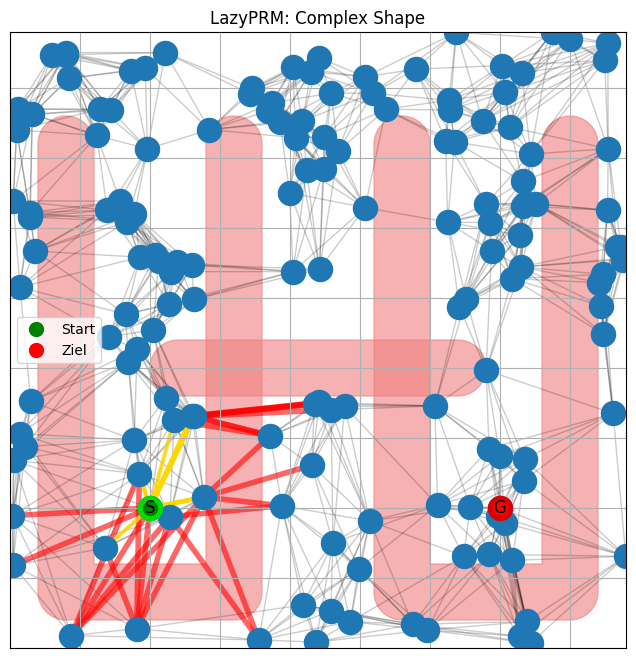


🔍 Szene: Multiple Obstacles
❌ Kein Pfad gefunden in Szene: Multiple Obstacles


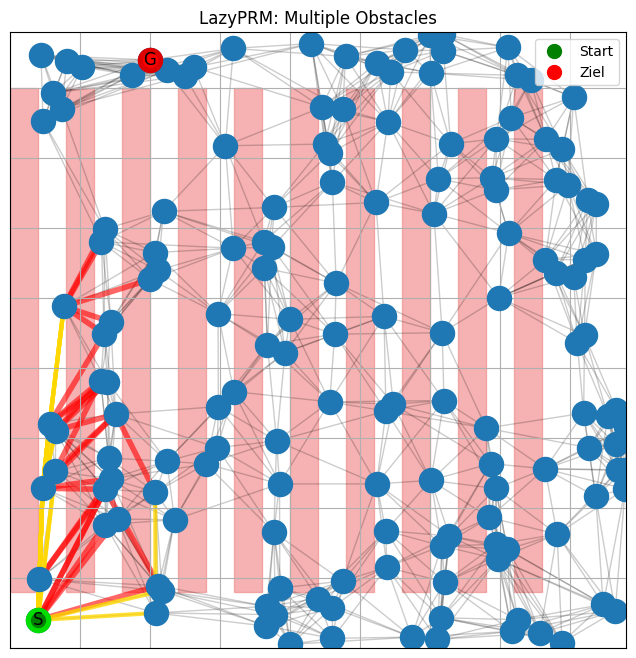


🔍 Szene: Crossed Obstacles
✅ Pfad gefunden in Szene: Crossed Obstacles, Länge: 12


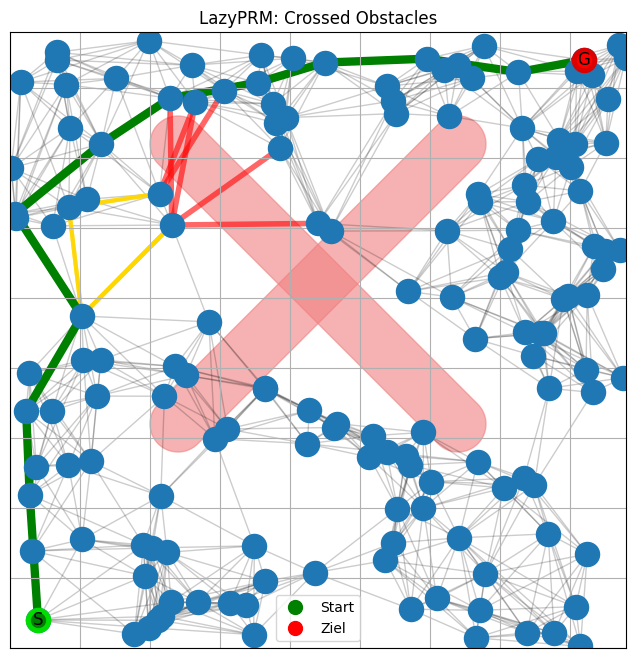


🔍 Szene: Random Obstacles
✅ Pfad gefunden in Szene: Random Obstacles, Länge: 10


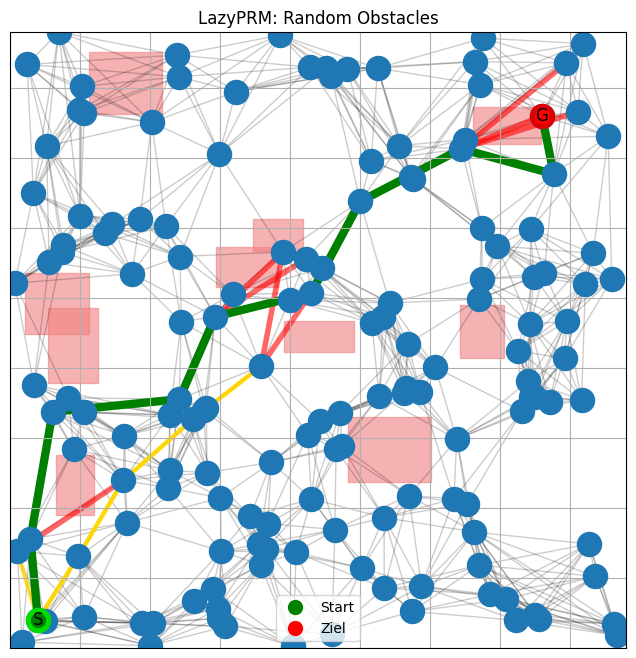

In [4]:
for scene_name, (scene, limits, (start_pos, goal_pos)) in scenes:
    print(f"\n🔍 Szene: {scene_name}")
    start = [list(start_pos)]
    goal = [list(goal_pos)]

    # CollisionChecker instanziieren
    collision_checker = CollisionChecker(scene, limits)

    # LazyPRM-Planer erstellen
    planner = LazyPRM(collision_checker, limits)

    # Planung mit Zeitmessung
    t0 = time.time()
    path = planner.plan_path(start, goal, config)
    t1 = time.time()

    coords = planner.get_path_coordinates(path) if path else []
    euclidean_length = sum(euclidean(a, b) for a, b in zip(coords[:-1], coords[1:])) if coords else 0

    if not path:
        print(f"❌ Kein Pfad gefunden in Szene: {scene_name}")
    else:
        print(f"✅ Pfad gefunden in Szene: {scene_name}, Länge: {len(path)}")

    # Visualisierung
    fig, ax = plt.subplots(figsize=(8, 8))
    lazy_prm_visualize(planner, solution=path, ax=ax)
    ax.set_title(f"LazyPRM: {scene_name}")
    ax.plot(start[0][0], start[0][1], "go", markersize=10, label="Start")
    ax.plot(goal[0][0], goal[0][1], "ro", markersize=10, label="Ziel")
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_aspect("equal")
    ax.grid(True)
    ax.legend()
    plt.show()

    result = {
        "scene": scene_name,
        "hasPath": bool(path),
        "length": len(path) if path else 0,
        "euclidean_length": euclidean_length,
        "time": t1 - t0,
        "nodes": len(planner.graph.nodes),
        "edges": len(planner.graph.edges),
        "roadmap_size": planner.graph.size()
    }
    results.append(result)


📊 Benchmark-Ergebnisse:
                scene  hasPath  length  euclidean_length      time  nodes  \
0             U-Shape     True      11         35.648913  0.011466    152   
1             L-Shape    False       0          0.000000  0.020826    152   
2            Corridor     True      13         41.862788  0.014584    152   
3       Complex Shape    False       0          0.000000  0.013263    152   
4  Multiple Obstacles    False       0          0.000000  0.017151    152   
5   Crossed Obstacles     True      12         37.690334  0.012633    152   
6    Random Obstacles     True      10         32.116954  0.015813    152   

   edges  roadmap_size  
0    869           869  
1    877           877  
2    854           854  
3    892           892  
4    839           839  
5    888           888  
6    873           873  
💾 Rohdaten gespeichert unter: benchmark_results\LazyPRM_results.csv


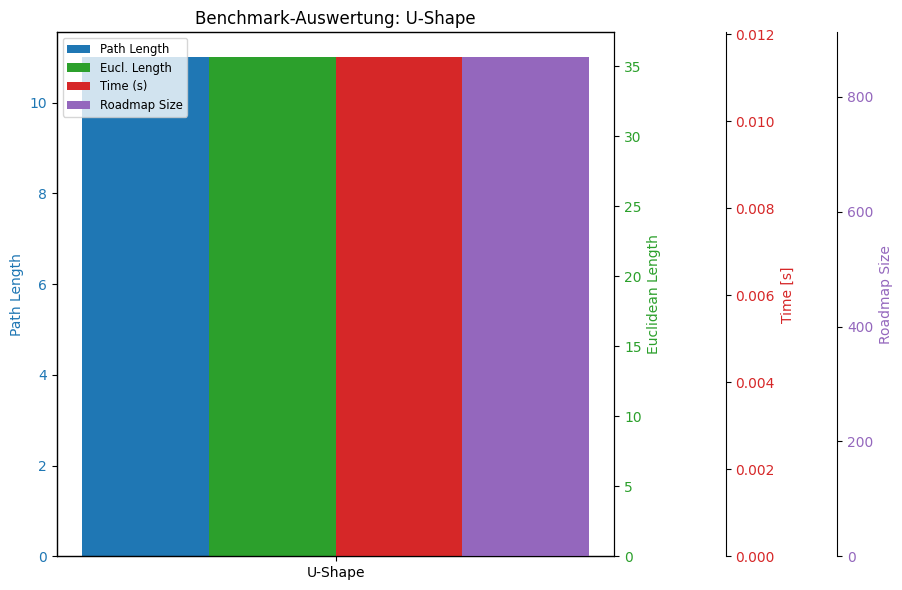

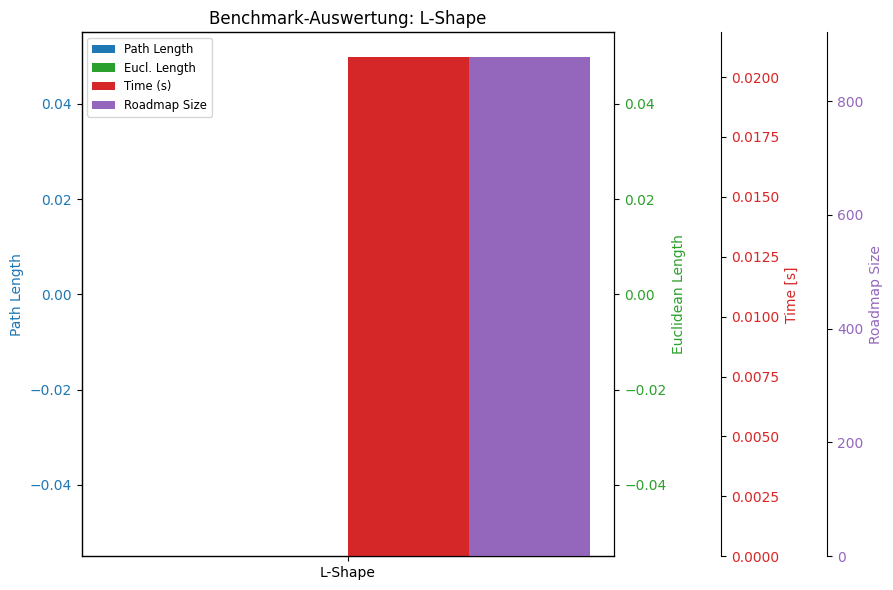

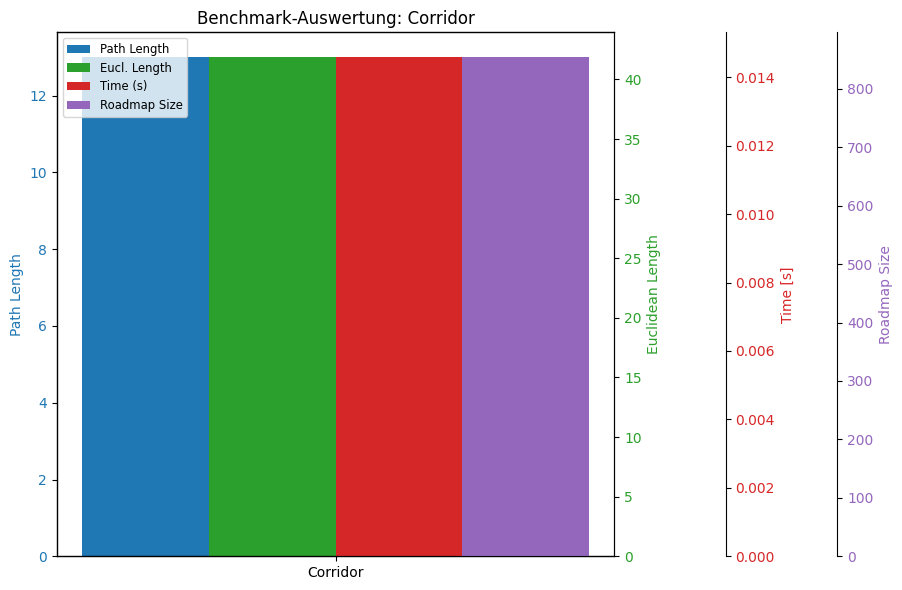

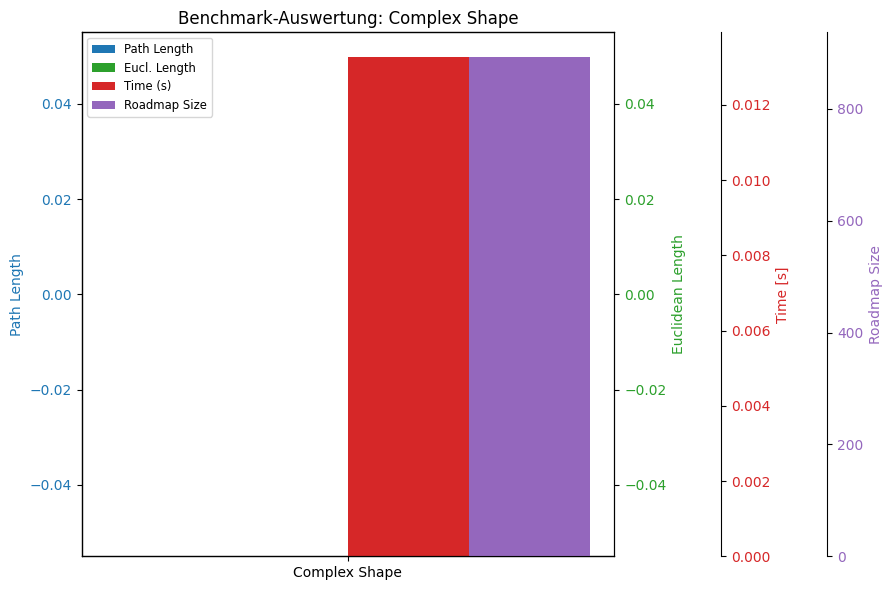

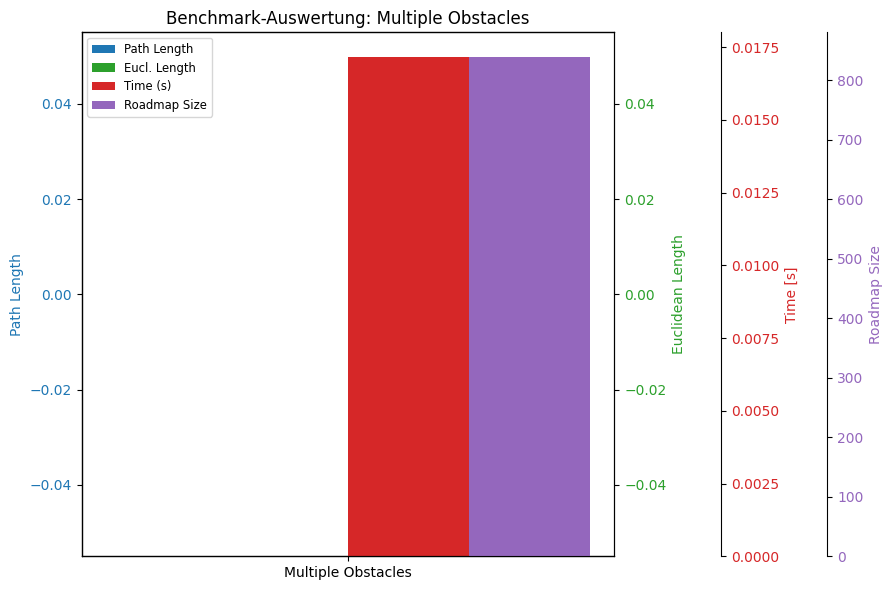

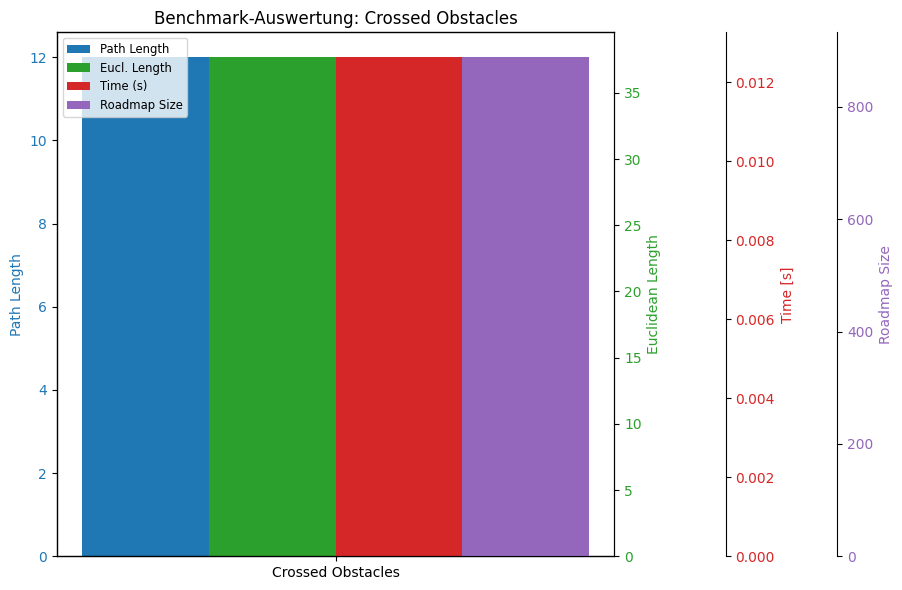

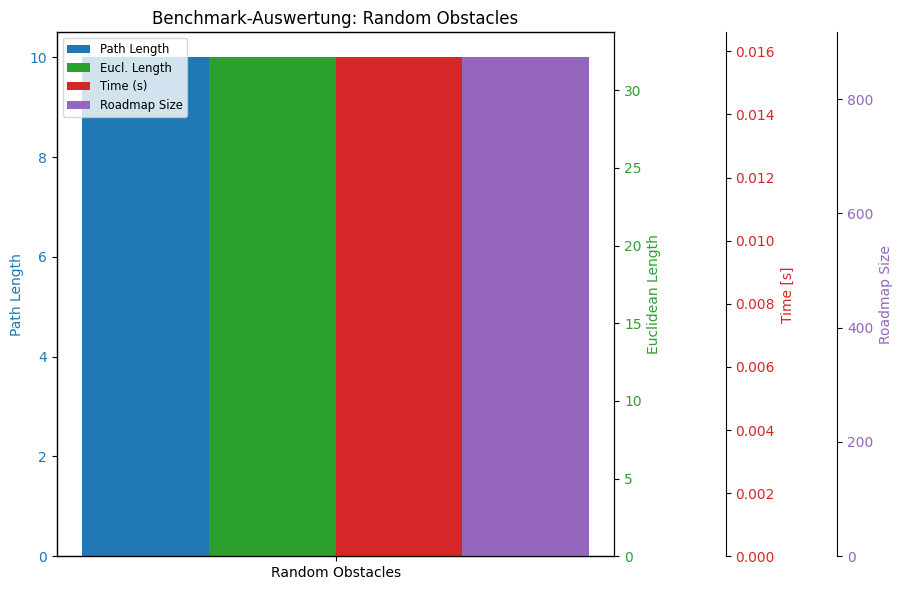

In [5]:
# Ergebnisse als DataFrame
result_df = pd.DataFrame(results)
print("\n📊 Benchmark-Ergebnisse:")
print(result_df)

import os

# Speicherpfad
results_dir = "benchmark_results"
os.makedirs(results_dir, exist_ok=True)

# Dateiname für BasicPRM
csv_path = os.path.join(results_dir, "LazyPRM_results.csv")

# Speichern
result_df.to_csv(csv_path, index=False)
print(f"💾 Rohdaten gespeichert unter: {csv_path}")
# Verbesserte Visualisierung
for scene in result_df["scene"].unique():
    df = result_df[result_df["scene"] == scene]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    width = 0.2
    idx = np.arange(1)

    ax1.bar(idx, df["length"], width, label="Path Length", color="#1f77b4")
    ax1.set_ylabel("Path Length", color="#1f77b4")
    ax1.tick_params(axis='y', labelcolor="#1f77b4")

    ax2 = ax1.twinx()
    ax2.bar(idx + width, df["euclidean_length"], width, label="Eucl. Length", color="#2ca02c")
    ax2.set_ylabel("Euclidean Length", color="#2ca02c")
    ax2.tick_params(axis='y', labelcolor="#2ca02c")

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('axes', 1.2))
    ax3.bar(idx + 2 * width, df["time"], width, label="Time (s)", color="#d62728")
    ax3.set_ylabel("Time [s]", color="#d62728")
    ax3.tick_params(axis='y', labelcolor="#d62728")

    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('axes', 1.4))
    ax4.bar(idx + 3 * width, df["roadmap_size"], width, label="Roadmap Size", color="#9467bd")
    ax4.set_ylabel("Roadmap Size", color="#9467bd")
    ax4.tick_params(axis='y', labelcolor="#9467bd")

    ax1.set_xticks(idx + 1.5 * width)
    ax1.set_xticklabels([scene])
    ax1.set_title(f"Benchmark-Auswertung: {scene}")

    handles, labels = [], []
    for ax in [ax1, ax2, ax3, ax4]:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    ax1.legend(handles, labels, loc="upper left", fontsize="small")

    plt.tight_layout()
    plt.show()
